## Imports

In [1]:
from ipynb.fs.full.Jacobian import *
from ipynb.fs.full.SubFunctions import *

import numpy as np
from numpy import linalg as LA
import sympy as sp

import matplotlib.pyplot as plt
import math

## Global Variables

In [2]:
#Time variables
interval = 10
delta = 0.01

#Numbers represent how far we want to be precised.
Epsilon = 10**-2
Nnewton = 10

## Solver for one differencial equation

In [3]:
def Solver_one_equation(expr, u0, use_trapezoidal):
    t0 = 0
    i = 1
    f_uk = 1
    uk_1 = u0
    nb = 0
    
    #Each list is an axis.
    #Time = [t0, t1, t2, ...., tn]
    #Function = [u0, u1, u2, ...., un]
    function = [u0]
    time = [t0]
    
    first = True
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        nb = 0
        #Newton's method
        while( nb < Nnewton):
            
            f_uk_1 = 0
            f_uk_1_prime = 0
            
            # First step, we change our equation to f(x) = 0
            f = create_f(u, uk_1, expr, use_trapezoidal)
            
            # We recup the term f(uk-1)
            if(first):
                f_uk_1 = f.subs(u, uk_1)
                first = False
            
            else:
                f_uk_1 = f.subs(u, function[i-1])
            
            #We recup the term f'(uk_1)
            f_uk_1_prime = Jacobian_one(f).subs(u, uk_1)

            #Formula : uk = uk_1 - (f(uk_1) / f'(uk_1))
            uk = uk_1 - (f_uk_1 / f_uk_1_prime)

            #Check the approximation. If f_uk < Epsilon = good approximation
            f_uk = f.subs(u, uk)
            
            uk_1 = uk
            if(f_uk < Epsilon):
                break
        
        #Update our 2 lists and indexes.
        time.append(t0)
        function.append(uk)
        f_uk = 1
        i += 1
        nb += 1

    return result_solver(time, function)

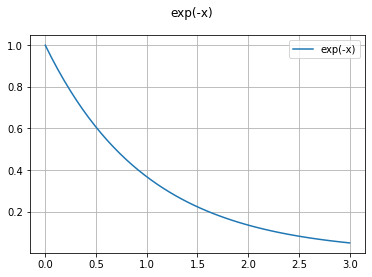

NameError: name 'delta' is not defined

In [4]:
fig, ax = plt.subplots()
x = np.linspace(0, 3, 50)
y = np.exp(-x)
ax.plot(x, y, label ='exp(-x)')
ax.grid(True)
plt.legend()  
plt.suptitle('exp(-x)')
plt.show()

u0 = 1
use_trapezoidal = True
res = Solver_one_equation(-u, u0, use_trapezoidal)


absi = []
for i in range(0, len(res)):
    absi.append(res[i][0])
coords = []
for j in range(0, len(res)):
    coords.append(res[j][1])
    
plt.ylim([0, 1])
plt.title('Approximation de exp(-x)')
plt.xlim([0, 3])
plt.grid(True)
plt.scatter(absi, coords, s=5)

## Solver for 2 differentials equations

In [ ]:
def Solver_two_equations(u0, v0, f1, f2, use_trapezoidal):
    t0 = 0
    f_xk = 1
    uk_1 = u0
    vk_1 = v0
    xk_1 = np.array([u0, v0])
    xn_1_global = np.array([u0, v0])
    
    #Each list is an axis.
    #Time = [t0, t1, t2, ...., tn]
    #Functions = [u0, u1, u2, ...., un]
    fu = [u0]
    fv = [v0]
    time = [t0]
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        nb = 0
        
        #Newton's method
        while(nb < Nnewton):
            nb+=1
            
            # First step, we change our equation to F(x) = 0
            vec_f = create_2_f(xn_1_global, f1, f2, use_trapezoidal)
            
            #Creating F(xk-1)
            F_xk_1 = create_fxk_1(xk_1, vec_f)
            
            #Creating F'(xk-1)
            F_xk_1_prime = f_prime_2_eqs(xk_1, vec_f[0], vec_f[1])
        
            
            #Formula : xk = xk_1 - tr(F'(xk_1)) * F(xk_1)
            xk = xk_1 - np.dot(LA.inv(F_xk_1_prime), F_xk_1)
          
            #2 types of check the approximation.
            f_xk =[0, 0]
            f_xk[0] = float(vec_f[0].evalf(subs={u: xk[0], v: xk[1]}))
            f_xk[1] = float(vec_f[1].evalf(subs={u: xk[0], v: xk[1]})) 
            norm_f_xk = LA.norm(f_xk)
            norm_xk = LA.norm(xk - xn_1_global)
            if(norm_xk < Epsilon or norm_f_xk < Epsilon):
                break
            
            xk_1 = xk
        
        #Update our 3 lists and indexes.
        time.append(t0)
        fu.append(xk[0])
        fv.append(xk[1])
        
        xn_1_global = np.array([xk[0],xk[1]])
        f_xk = 1        
      
    return result_solver(time, fu, fv)

In [ ]:
u0 = 1
v0 = 1

du = v
dv = -u
use_trapezoidal = True
res = Solver_two_equations(u0, v0, du, dv, use_trapezoidal)


time = []
coords_u = []
coords_v = []

for i in range(0, len(res[0])):
    time.append(res[0][i][0])
    coords_u.append(res[0][i][1])
    coords_v.append(res[1][i][1])

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(time, coords_u, s=10, label='approximtion de u')
ax1.scatter(time, coords_v, s=10, label='approximation de v')
ax1.grid(True)
plt.xlim([0, 10])
plt.ylim([-10, 10])
plt.legend(loc='upper left');
plt.show()

graph = plt.subplot()
x = np.linspace(0, 9)
y = np.cos(x) + np.sin(x)
z = np.cos(x) - np.sin(x)
graph.plot(x, y, label ='u(t) = cos(t) + sin(t)')
graph.plot(x, z, label ='v(t) = cos(t) - sin(t)')
graph.grid(True)
plt.legend(loc='upper left')  
plt.show()

In [ ]:
u0 = 0
v0 = 1

du = 3*u + 4*v
dv = -4*u + 3*v

res = Solver_two_equations(u0, v0, du, dv, True)

time = []
coords_u = []
coords_v = []

for i in range(0, len(res[0])):
    time.append(res[0][i][0])
    coords_u.append(res[0][i][1])
    coords_v.append(res[1][i][1])

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(time, coords_u, s=5, label='approximtion de u')
ax1.scatter(time, coords_v, s=5, label='approximation de v')
ax1.grid(True)
plt.xlim([0, 3])
plt.ylim([-4000, 6000])
plt.legend(loc='upper left');
plt.show()

graph = plt.subplot()
x = np.linspace(0, 3)
y = np.sin(4*x) * np.exp(3*x)
z = np.cos(4*x) * np.exp(3*x)
graph.plot(x, y, label ='u(t) = sin(4t) * exp(3t)')
graph.plot(x, z, label ='v(t) = cos(4t) * exp(3t)')
graph.grid(True)
plt.legend()  
plt.show()

## Solver for 4 differentials equations

In [ ]:
def Solver_4_equations(u0, v0, f1, f2):
    t0 = 0
    f_xk = 1
    uk_1 = u0
    vk_1 = v0
    xk_1 = np.array([u0, v0])
    xn_1_global = np.array([u0, v0])
    
    #Each list is an axis.
    #Time = [t0, t1, t2, ...., tn]
    #Functions = [u0, u1, u2, ...., un]
    fu = [u0]
    fv = [v0]
    time = [t0]
    
    #Suit of x and y variables
    y0 = u0*v0
    x0 = u0 + v0 - y0
    x = [x0]
    y = [y0]
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        nb = 0
        
        #Newton's method
        while(nb < Nnewton):
            nb+=1
            
            # First step, we change our equation to F(x) = 0
            vec_f = create_2_f(xn_1_global, f1, f2)
            
            #Creating F(xk-1)
            F_xk_1 = create_fxk_1(xk_1, vec_f)
            
            #Creating F'(xk-1)
            F_xk_1_prime = f_prime_2_eqs(xk_1, vec_f[0], vec_f[1])
        
            #Formula : xk = xk_1 - tr(F'(xk_1)) * F(xk_1)
            xk = xk_1 - np.dot(LA.inv(F_xk_1_prime), F_xk_1)
            
            #With the uk+1 and vk+1 calculated, we can calcul the x and y value.
            next_y = xk[0]*xk[1]
            next_x = xk[0] + xk[1] - next_y
            
            #Calcul of f(uk, vk, xk, yk) for the approximation
            f_xk = [0, 0, 0, 0]
            f_xk[0] = float(vec_f[0].evalf(subs={u: xk[0], v: xk[1]}))
            f_xk[1] = float(vec_f[1].evalf(subs={u: xk[0], v: xk[1]}))
            f_xk[2] = float(next_x)
            f_xk[3] = float(next_y)
            
            #2 types of check the approximation.
            norm_f_xk = LA.norm(f_xk)
            norm_xk = LA.norm(xk - xn_1_global)
            
            if(norm_xk < Epsilon or norm_f_xk < Epsilon):
                break
            
            xk_1 = xk
        
        #Update our 2 functions + time
        time.append(t0)
        fu.append(xk[0])
        fv.append(xk[1])
        
        #Update x and y variables
        x.append(next_x)
        y.append(next_y)
            
        #Update indexes
        xn_1_global = np.array([xk[0],xk[1]])
        f_xk = 1        
      
    return result_solver(time, fu, fv, x, y)